In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u

deg = np.pi/180.

# Astrometric Orbits with Exoplanet

In this notebook we'll walk through the astrometric functionalities of `exoplanet` and how they can be used to fit a variety of systems, including those with parallax and radial velocity measurements. 

To start, we'll start with the simplest example (in terms of number of parameters), which is fitting an orbit of a binary star system that only has astrometric measurements of the separation and orientation of the two stars as a function of time. 

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). There are also radial velocities from [Tokovinin 1993](https://ui.adsabs.harvard.edu/#abs/1993AstL...19...73T/abstract), which we'll use later on. We'll follow the conventions from Pourbaix et al., which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer. 

In [4]:
# grab the formatted data and do some munging
astro_url = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/astro.txt"
rv1_url = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/rv1.txt"
rv2_url = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/rv2.txt"

astro_data_full = ascii.read(astro_url, format="csv", fill_values=[(".", '0')])

In [16]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the following highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements do not have associated error measurements. For these, we assume a modest estimate of $5^\circ$ in position angle and $0.05"$ in separation to get a preliminary fit. The scatter in points around the final solution will be a decent guide of what the systematics in the measurement uncertainty actually were.

In [17]:
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 2.0

In [18]:
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.02

In [19]:
rho_data = np.array(astro_data["rho"].data.data) # arcsec
rho_err = np.array(astro_data["rho_err"].data.data) # arcsec

theta_data = np.array(astro_data["PA"].data.data * deg) # radians # needs to be in range of -pi to pi
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.array(astro_data["PA_err"].data.data * deg) # radians

# and here is the full table
astro_data

date,PA,PA_err,rho,rho_err
float64,float64,float64,float64,float64
1976.8571,139.1,0.5,0.168,0.004
1976.9226,139.6,0.3,0.171,0.001
1977.6352,134.8,2.0,0.15,0.02
1977.7335,136.5,0.4,0.147,0.009
1977.9164,130.5,2.0,0.125,0.02
1978.6154,128.3,1.0,0.108,0.009
1979.7731,124.0,2.0,0.102,0.02
1980.7179,106.0,2.0,0.075,0.02
1982.7657,57.8,2.0,0.061,0.02


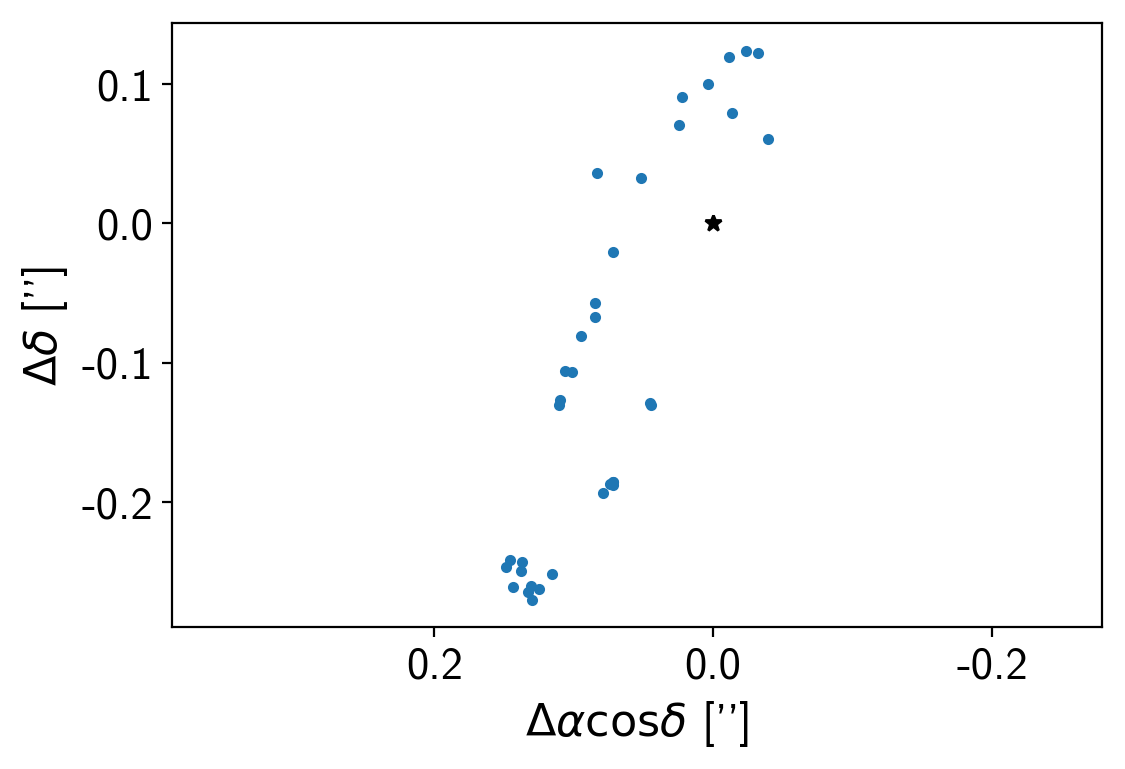

In [20]:
# normally, we assume that rho is measured in degrees east of north

# Make a plot of the astrometric data on the sky

fig, ax = plt.subplots(nrows=1)

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky makes the most sense for interpreting the physical scale of the orbit, but when traditional astrometric measurements are made of a secondary star, they are usually made as the separation and angle from the primary star. This means that the "raw" measurements are the values of $\rho$ (separation) and P.A. (position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

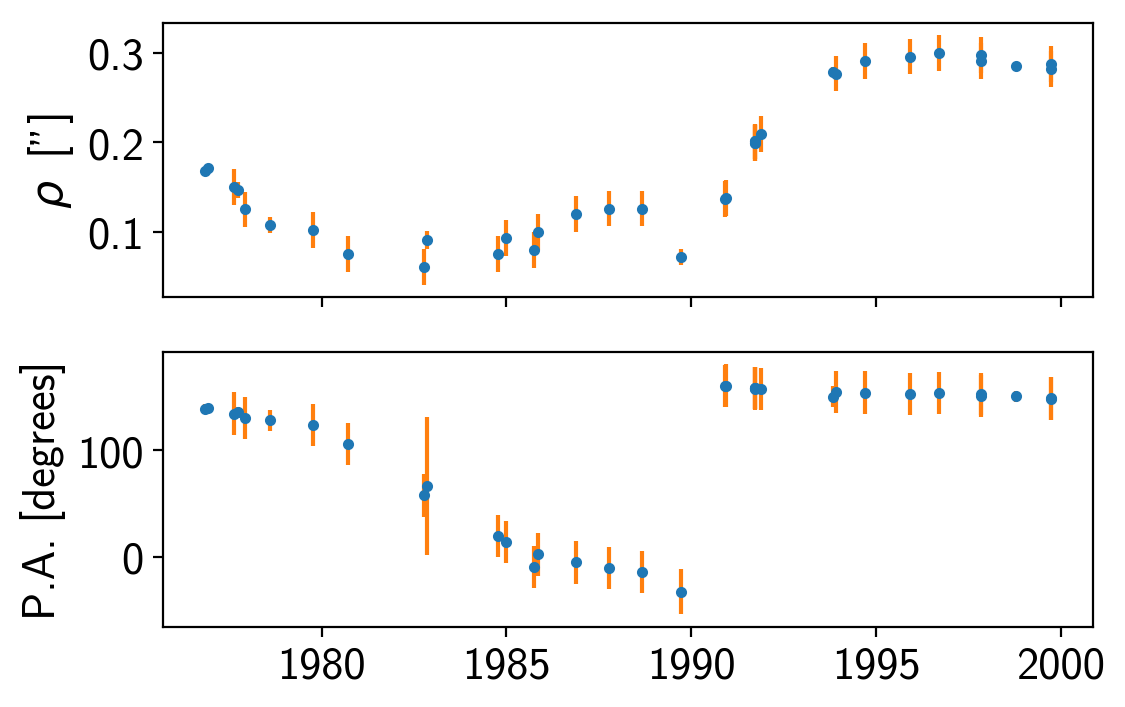

In [21]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(astro_yrs, rho_data, ".")
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data/deg, ".")
ax[1].errorbar(astro_yrs, theta_data/deg, yerr=10 * theta_err/deg, ls="")
ax[1].set_ylabel(r'P.A. [degrees]');

In [11]:
# this is the way the orbit is plotted in Hartkopf et al. 1996

# fig, ax = plt.subplots(nrows=1)

# xs = rho_data * np.cos(theta_data * deg) # X is north
# ys = rho_data * np.sin(theta_data * deg) # Y is east
# ax.plot(ys[ind], xs[ind], ".")
# ax.set_ylabel(r"$\Delta \delta$ ['']")
# ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
# ax.invert_yaxis()
# ax.plot(0,0, "k*")
# ax.set_aspect("equal", "datalim")

In [22]:
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo

import exoplanet.orbits
from exoplanet.distributions import Angle

In [48]:
# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a = 0.324 # arcsec
e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg # omega_2 according to Pourbaix RV equations
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]
T0_start = T0
# n = 2 * np.pi / P
# t0 = (phi + w) / n

# instantiate the orbit
# orbit = astro.AstrometricOrbit(a_ang=a, t0=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega)

# # make a theano function to get stuff from orbit 
# times = tt.vector("times")
# ang = orbit.get_relative_position(times) # the rho, theta measurements
# pos = orbit.get_relative_position_XY(times) # the Dec, RA measurements
# anom = orbit._get_true_anomaly(times)


# f_anom = theano.function([times], anom)
# f_ang = theano.function([times], ang)
# f_pos = theano.function([times], pos)

# t = np.linspace(T0 - P, T0 + P, num=200) # days

# anoms = f_anom(t)
# rho, theta = f_ang(t)
# X, Y = f_pos(t)

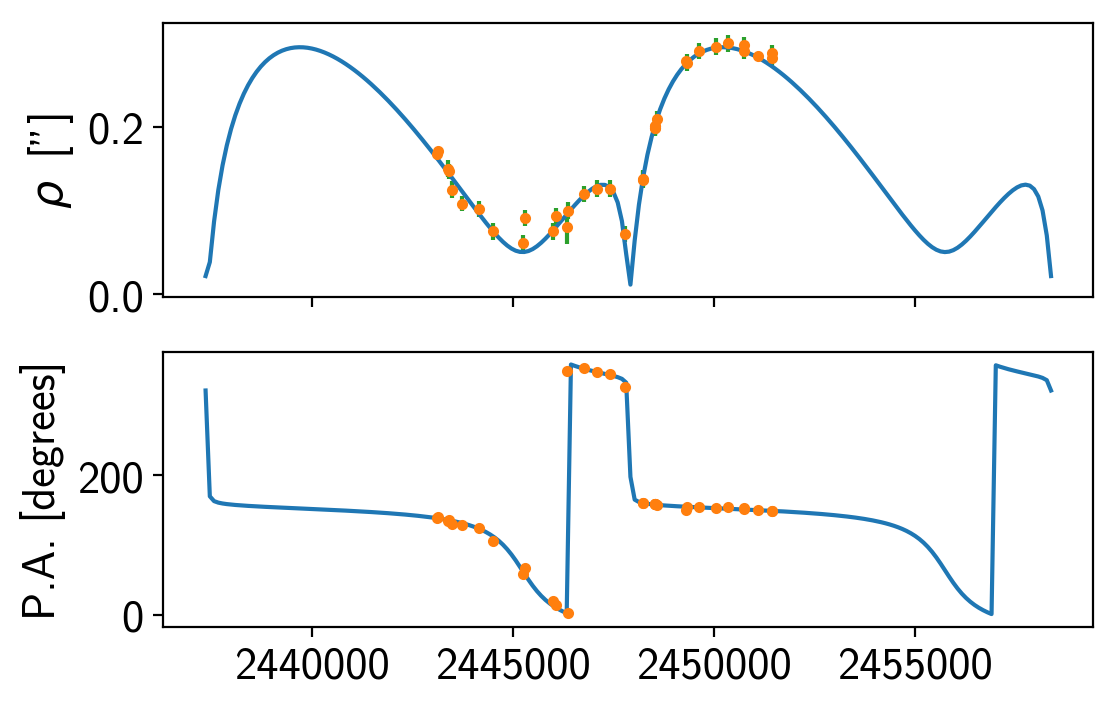

In [31]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(t, rho)
ax[0].plot(astro_jds, rho_data, ".")
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

theta_wrap = theta 
theta_wrap[theta_wrap < 0] += 2 * np.pi

ax[1].plot(t, theta/deg)
ax[1].plot(astro_jds, theta_data/deg, ".")
ax[1].errorbar(astro_jds, theta_data/deg, yerr=theta_err/deg, ls="")
ax[1].set_ylabel(r'P.A. [degrees]');

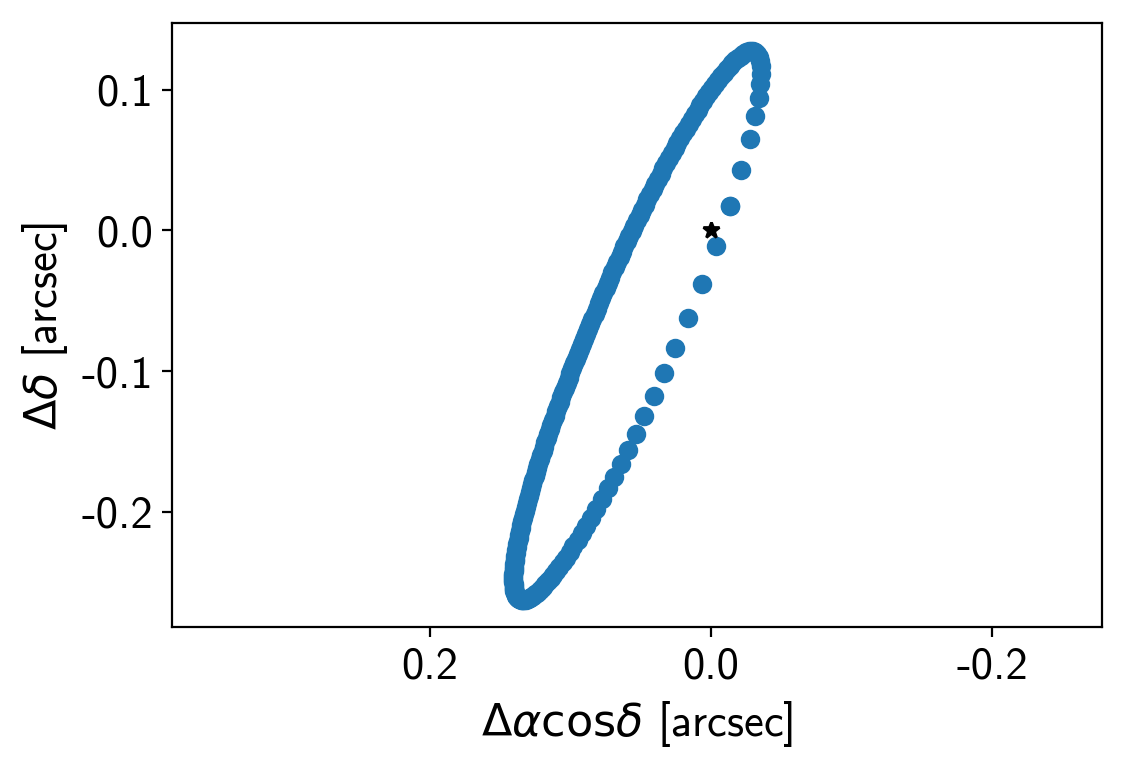

In [32]:
fig, ax = plt.subplots(nrows=1)
ax.plot(Y, X, "o")
ax.plot(0, 0, "k*")
ax.invert_xaxis()
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [arcsec]")
ax.set_ylabel(r"$\Delta \delta$ [arcsec]");
ax.set_aspect("equal", "datalim")

Orbit fitting tip from Mike Fitzgerald to use $\Omega+\omega$ and $\Omega-\omega$ for fitting, since you can get unambiguous constraints on those parameters. 

Without radial velocity information, there is a $180^\circ$ degeneracy in the position angle of the ascending node, $\Omega_2$.

In [160]:
# Sample the orbit 

with pm.Model() as model:

    # A setup for a basic astrometric binary orbit
    parallax = 1 # arcsec 
    a_ang = pm.Normal("a_ang", 0.1, 10.0) # arcsec 
    a = pm.Deterministic("a", a_ang * parallax)
    
    
    logP = pm.Uniform("logP", lower=np.log(25 * 365.25), upper=np.log(30 * 365.25), testval=np.log(28.8 * 365.25))
    P = pm.Deterministic("P", tt.exp(logP))
    
    omega = Angle("omega") # - pi to pi
    Omega = Angle("Omega") # - pi to pi
    
    # orbital phase 
    phi = Angle("phi") # - pi to pi
    
    n = 2 * np.pi * tt.exp(-logP)
    t_periastron = (phi + omega) / n # a reference time for periastron passage
    
    
    incl = pm.Uniform("incl", lower=0, upper=np.pi) # radians, 0 to 180 degrees
    e = 0.798
#     e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
    
    # Deterministic transformations
#     n = 2 * np.pi / P # radians / day
#     T0 = (phi + omega) / n # calculate epoch of periastron for initialization

    
#     T0 = pm.Uniform("T0", lower=T0_start - 10**5, upper=T0_start + 10**5, testval=T0_start)
       
    orbit = astro.AstrometricOrbit(a_ang=a, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega)
    
    rho_model, theta_model = orbit.get_relative_position(astro_jds) # the rho, theta measurements
    
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_err)
#     pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_err)
    
    #     T0_print = tt.printing.Print("T0")(T0)
    #     rho_print = tt.printing.Print('rho')(rho_model)
    #     theta_print = tt.printing.Print('theta')(theta_model)

In [155]:
model.test_point

{'a_interval__': array(0.57536414), 'logP_interval__': array(1.24307561)}

In [161]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logP_interval__', 'a_interval__']
message: Optimization terminated successfully.
logp: -227602.88240001225 -> -199439.91123861648


In [162]:
print(map_sol)

{'a_interval__': array(0.51173869), 'logP_interval__': array(-10.07071435), 'a': array(0.28756419), 'logP': array(9.11946559), 'P': array(9131.32041998)}


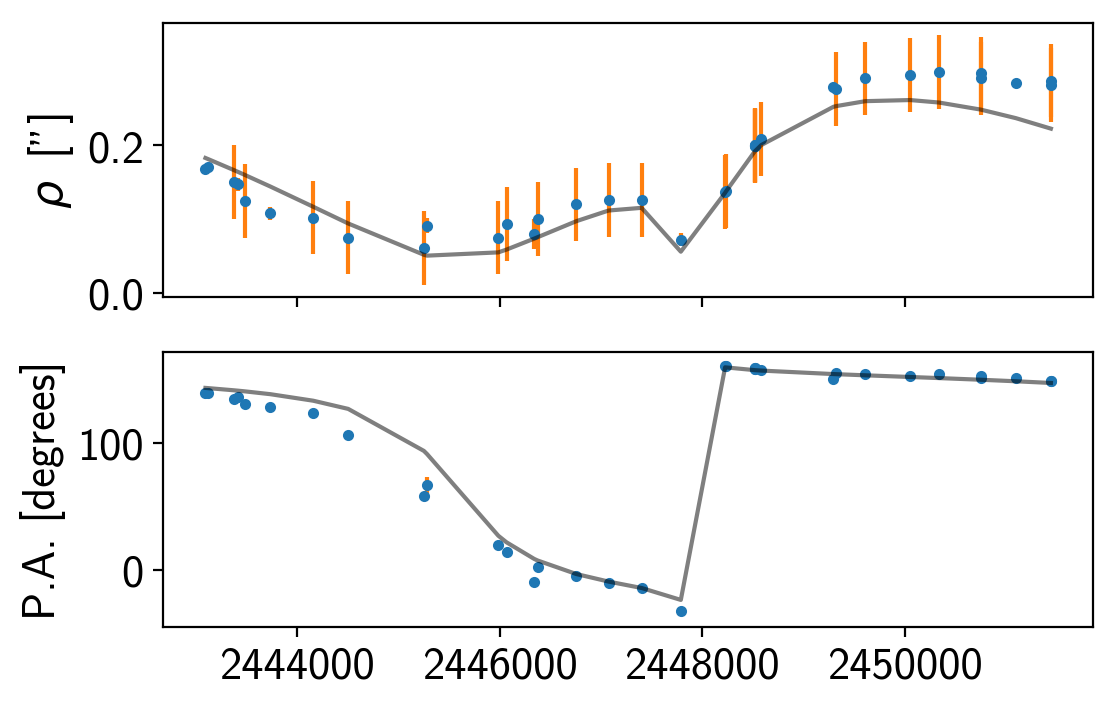

In [163]:
fig, ax = plt.subplots(nrows=2, sharex=True)
# ax[0].plot(t, rho)
ax[0].plot(astro_jds, rho_data, ".")
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

# ax[1].plot(t, theta/deg)
ax[1].plot(astro_jds, theta_data/deg, ".")
ax[1].errorbar(astro_jds, theta_data/deg, yerr=theta_err/deg, ls="")
ax[1].set_ylabel(r'P.A. [degrees]');

#{"P":, "T0":}
with model:
    
    ax[0].plot(astro_jds, xo.eval_in_model(rho_model, map_sol), "k", alpha=0.5)
    ax[1].plot(astro_jds, xo.eval_in_model(theta_model, map_sol)/deg, "k", alpha=0.5)

In [153]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(draws=5000, tune=1000, step=step, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [logP]
>Metropolis: [a]
100%|██████████| 6000/6000 [00:02<00:00, 2835.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/ian/.build/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9185c2a390>,
      dtype=object)

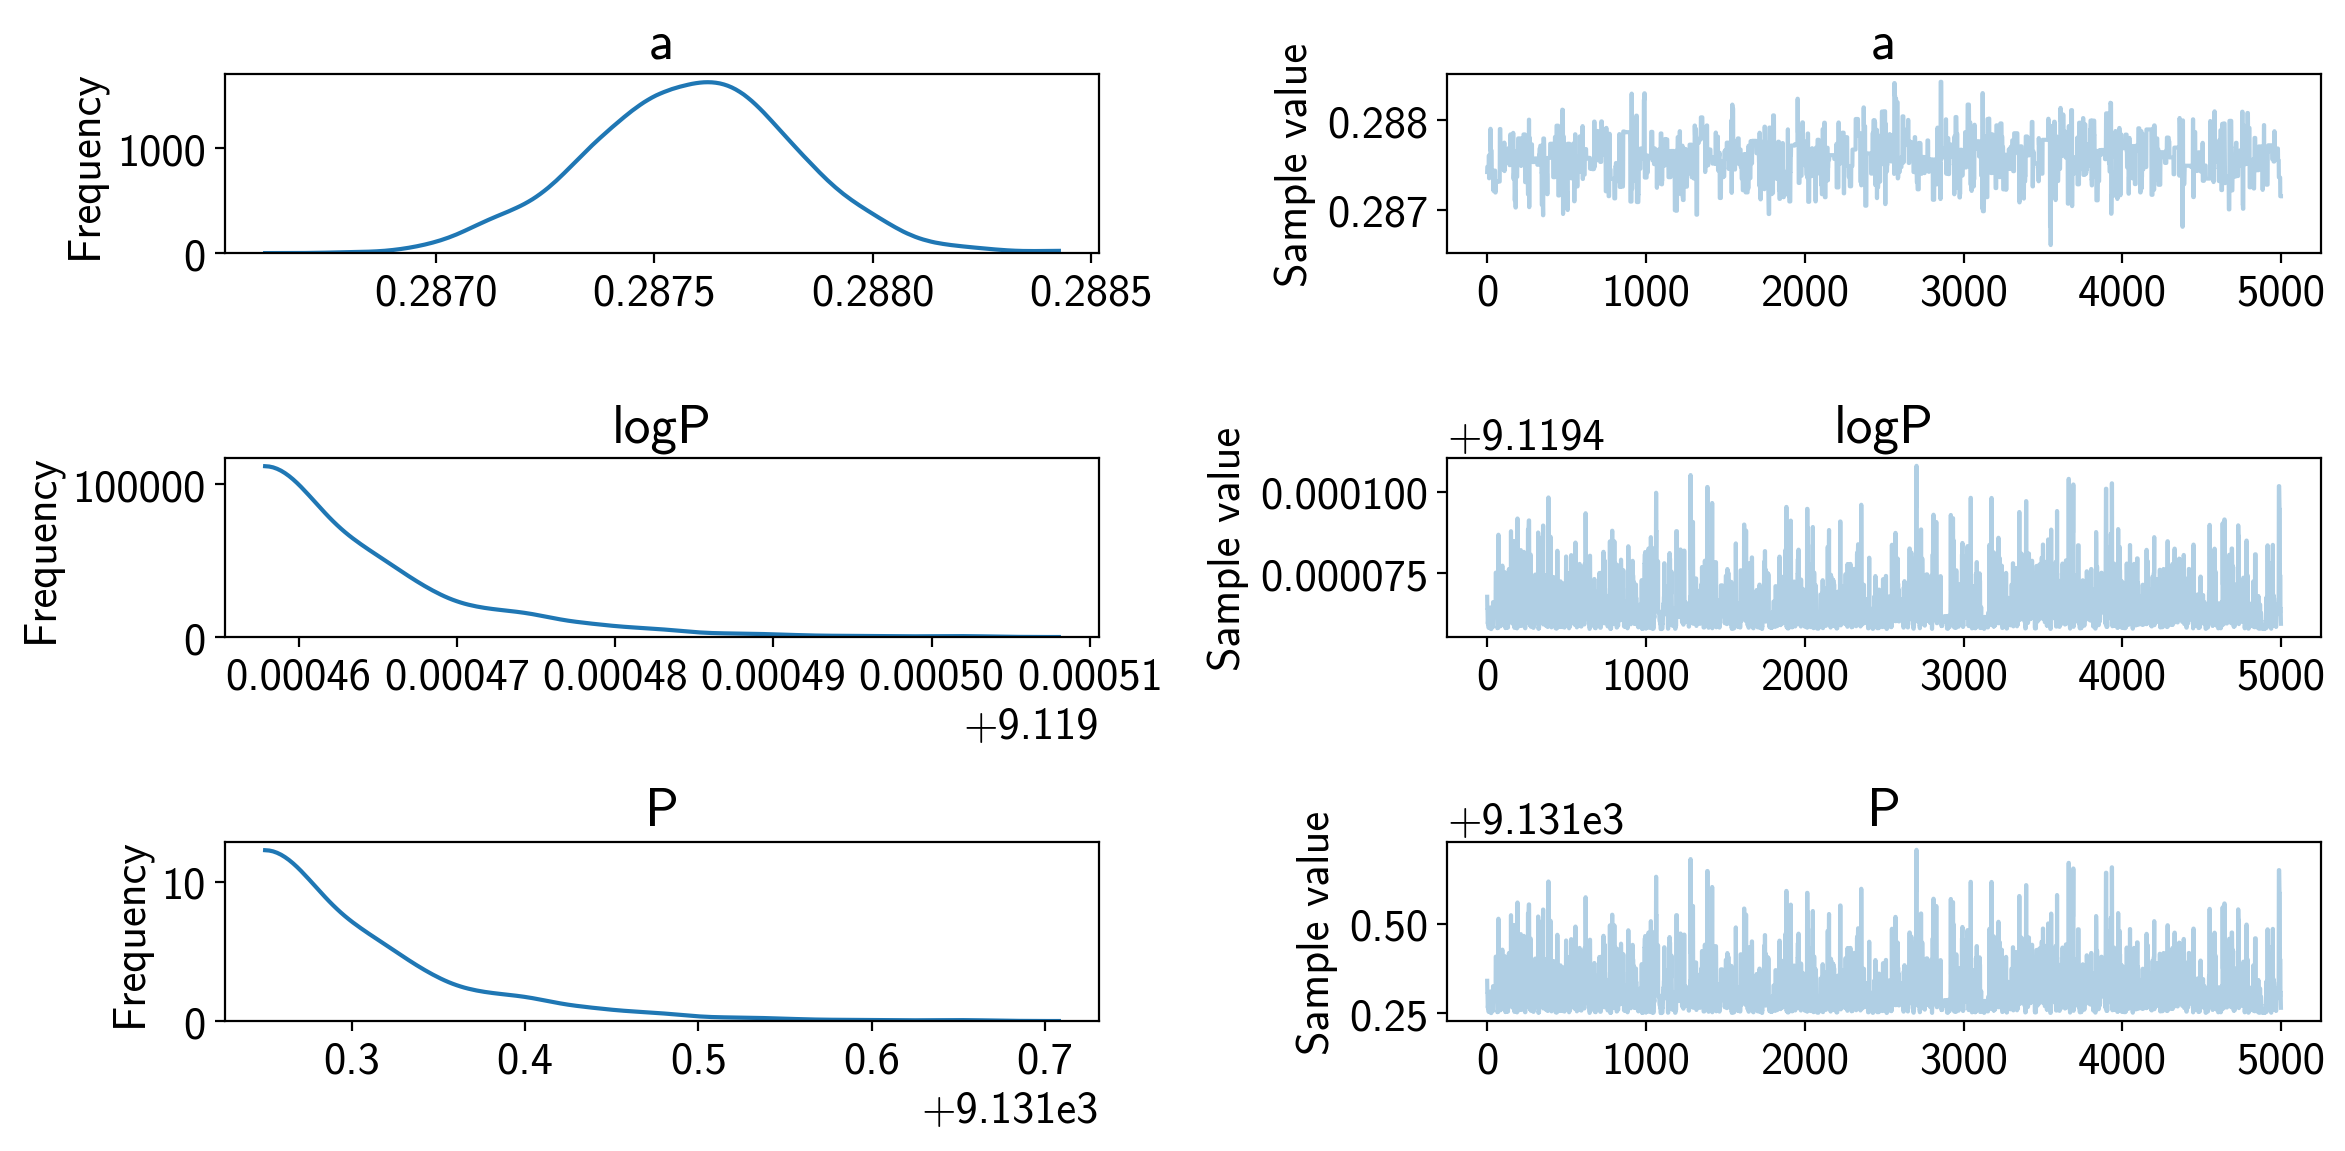

In [154]:
pm.traceplot(trace)